In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data_train = pd.read_csv("train.csv", index_col=0)
data_test = pd.read_csv("test.csv", index_col=0)

X = data_train.drop(labels=["stroke"], axis=1)
y = data_train["stroke"]

X_sub = data_test

## Support function

### Function to analyze the significance of features

In [3]:
def woe(data, value):
    value_data = data[data.iloc[:,0] == value]
    non_events = len(value_data[value_data.iloc[:,1] == 0]) / len(data[data.iloc[:,1] == 0]) * 100
    events = len(value_data[value_data.iloc[:,1] == 1]) /len(data[data.iloc[:,1] == 1]) * 100
    if events == 0:
            events += 0.5
    if non_events == 0:
        non_events += 0.5
    woe = np.log(non_events / events)
    return woe

In [4]:
def lv(data):
    lv = 0
    for value in np.unique(data.iloc[:,0]):
        value_data = data[data.iloc[:,0] == value]
        non_events = len(value_data[value_data.iloc[:,1] == 0]) / len(data[data.iloc[:,1] == 0]) * 100
        events = len(value_data[value_data.iloc[:,1] == 1]) /len(data[data.iloc[:,1] == 1]) * 100
        non_events += 0.5
        events += 0.5
        woe = np.log(non_events / events)
        lv += (non_events - events) * woe
    return lv

In [5]:
def convert(intervals, value):
    for i in range(len(intervals)-1):
        if value >= intervals[i] and value <= intervals[i+1]:
            return i

In [6]:
def create_bins(data, n):
    min_value = min(data)
    max_value = max(data)
    
    intervals = np.linspace(min_value, max_value, n, endpoint=True)

    output = [convert(intervals, x) for x in data]
    
    return output

### Function for transform features

In [7]:
def one_hot_encoding(data, binary_features):
    binary_data = pd.DataFrame(index=data.index)
    for feature in binary_features:
        pd_binary_data = data[[feature]].dropna(axis=0)

        binarizer = LabelBinarizer()
        one_binary_data = binarizer.fit_transform(pd_binary_data)

        if len(binarizer.classes_) == 2:
            one_binary_data = pd.DataFrame(one_binary_data, index=pd_binary_data.index, columns=[feature])
        else:
            one_binary_data = pd.DataFrame(one_binary_data, index=pd_binary_data.index, 
                                           columns=[f"{feature}_{x}" for x in binarizer.classes_])

        binary_data = pd.merge(binary_data, one_binary_data, how="left", left_index=True, right_index=True)
    binary_data.fillna(0, inplace=True)
    return binary_data

# Preprocessing data

In [8]:
print(data_train.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


(array([ 4188.,     0., 17220.,     0.,     0.,   115.,     0.,  4674.,
            0.,  3804.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

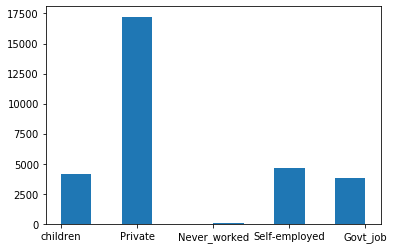

In [9]:
plt.hist(data_train["work_type"])

In [10]:
binary_features = ["hypertension", "heart_disease", 
                  "ever_married", "Residence_type"]
linear_features = ["age", "avg_glucose_level", "bmi"]
multilabel_features = ["gender", "work_type", "smoking_status"]

Check NaN value in data

In [11]:
for column in data_train.columns:
    print(f"{column}\t{len(data_train) - len(data_train.dropna(subset=[column]))}")

gender	0
age	0
hypertension	0
heart_disease	0
ever_married	0
work_type	0
Residence_type	0
avg_glucose_level	0
bmi	1017
smoking_status	9176
stroke	0


BMI's NaN value will replace to mean value based on general thoughts

In [12]:
mean_bmi = np.mean(data_train["bmi"].dropna())
data_train["bmi"] = data_train["bmi"].fillna(mean_bmi)
data_test["bmi"] = data_test["bmi"].fillna(mean_bmi)

In [13]:
## Transform binary features
for feature in binary_features:
    data_train[feature] = one_hot_encoding(data_train, [feature])
    data_test[feature] = one_hot_encoding(data_test, [feature])

In [14]:
## Tranform gender feature
gender_data_train = pd.DataFrame()
gender_data_test = pd.DataFrame()
gender_data_train["gender"] = data_train["gender"]
gender_data_test["gender"] = data_train["gender"]
data_train.drop(labels=["gender"], axis=1, inplace=True)
data_test.drop(labels=["gender"], axis=1, inplace=True)

data_train = pd.concat([data_train, one_hot_encoding(gender_data_train, ["gender"])], axis=1)
data_test = pd.concat([data_test, one_hot_encoding(gender_data_test, ["gender"])], axis=1)

In [15]:
## Tranform work type feature
work_data_train = pd.DataFrame()
work_data_test = pd.DataFrame()
work_data_train["work_type"] = data_train["work_type"]
work_data_test["work_type"] = data_train["work_type"]
data_train.drop(labels=["work_type"], axis=1, inplace=True)
data_test.drop(labels=["work_type"], axis=1, inplace=True)

data_train = pd.concat([data_train, one_hot_encoding(work_data_train, ["work_type"])], axis=1)
data_test = pd.concat([data_test, one_hot_encoding(work_data_test, ["work_type"])], axis=1)

In [16]:
# Analysis NaN value in smoking_status column using lv
for value in ['formerly smoked', 'never smoked', 'smokes']:
    temp = deepcopy(data_train[["smoking_status", "stroke"]])
    temp.fillna(value, inplace=True)
    print(f"{value}:")
    print(lv(temp))

formerly smoked:
0.23538788241138475
never smoked:
7.025205952059387
smokes:
6.593940758501628


Using instead of NaN value -> never smoked value

In [17]:
data_train.fillna('never smoked', inplace=True)
data_test.fillna('never smoked', inplace=True)

In [18]:
smoking_status_dict = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2}
data_train.replace(smoking_status_dict, inplace=True)
data_test.replace(smoking_status_dict, inplace=True)

## Feature selection

In [19]:
# Set threshold to lv analysis - 1
thr = 1
linear_features = ["age", "avg_glucose_level", "bmi"]
others_features = list(set(data_train.columns) - set(linear_features))
lv_features = []
for linear_feature in linear_features:
    invest_data = pd.DataFrame(create_bins(data_train[linear_feature], 10), index=data_train.index)
    lv_value = lv(pd.concat([invest_data, data_train['stroke']], axis=1))
    print(f"{linear_feature}: {lv_value}")
    if lv_value > thr:
        lv_features.append(linear_feature)
    
for other_feature in others_features:
    lv_value = lv(data_train[[other_feature, 'stroke']])
    print(f"{other_feature}: {lv_value}")
    if lv_value > thr:
        lv_features.append(other_feature)

age: 176.69439869657748
avg_glucose_level: 33.575124346884344
bmi: 16.91205245025645
heart_disease: 27.06865559862513
work_type_Self-employed: 9.871675417608534
work_type_children: 41.03071118249582
Residence_type: 0.04443331135239037
smoking_status: 7.025205952059387
work_type_Never_worked: 0.2266145772527963
gender_Female: 0.5536056633444901
work_type_Private: 0.09102708379766498
work_type_Govt_job: 0.004683103094695176
ever_married: 38.44872819820584
hypertension: 19.326304810809738
gender_Male: 0.5638650087199448
gender_Other: 0.0022394029168574356
stroke: 1060.6609816118153


In [20]:
# We select these features based on lv
print(lv_features)

['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'work_type_Self-employed', 'work_type_children', 'smoking_status', 'ever_married', 'hypertension', 'stroke']


## Deleting outliers

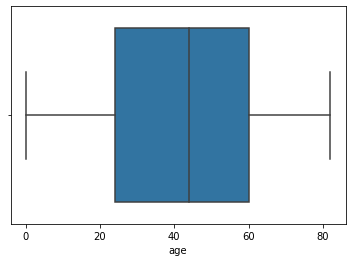

In [21]:
# Age data hasn't outliers
sns.boxplot(x=data_train["age"])

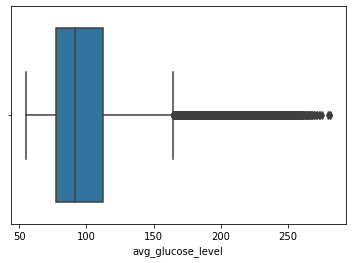

In [22]:
sns.boxplot(x=data_train["avg_glucose_level"])

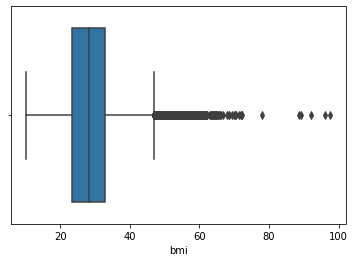

In [23]:
sns.boxplot(x=data_train["bmi"])

(array([11506., 10153.,  4684.,   462.,   641.,   992.,   930.,   465.,
          145.,    23.]),
 array([4.48766964e-05, 4.09266477e-01, 8.18488077e-01, 1.22770968e+00,
        1.63693128e+00, 2.04615288e+00, 2.45537448e+00, 2.86459608e+00,
        3.27381768e+00, 3.68303928e+00, 4.09226088e+00]),
 <a list of 10 Patch objects>)

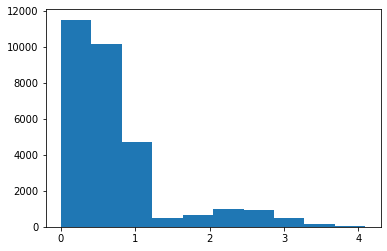

In [24]:
# Thr = 3.5 for z-score
z = np.abs(stats.zscore(data_train["avg_glucose_level"]))
plt.hist(z)

In [25]:
thr = 3.5
data_train = data_train[z < thr]

(array([1.989e+04, 8.307e+03, 1.304e+03, 3.130e+02, 9.500e+01, 2.300e+01,
        6.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([8.14720018e-04, 9.02228702e-01, 1.80364268e+00, 2.70505667e+00,
        3.60647065e+00, 4.50788463e+00, 5.40929861e+00, 6.31071260e+00,
        7.21212658e+00, 8.11354056e+00, 9.01495454e+00]),
 <a list of 10 Patch objects>)

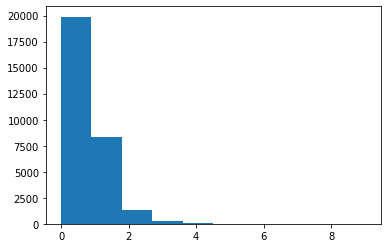

In [26]:
# thr = 3
z = np.abs(stats.zscore(data_train["bmi"]))
plt.hist(z)

In [27]:
thr = 3
data_train = data_train[z < thr]

## Scaling linear features

In [28]:
scaler = StandardScaler()
data_train[linear_features] = scaler.fit_transform(data_train[linear_features])
data_test[linear_features] = scaler.transform(data_test[linear_features])

## Search high correlation

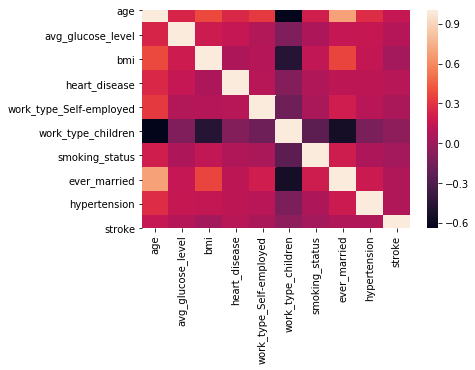

In [29]:
# Negative correlation is the result of converting features
# We can see correlation between age and ever married (that's obvious)
# Probably we remove ever_married feature in future
sns.heatmap((data_train[lv_features]).corr())

And that's the end of processing data

# Check models

In [30]:
def get_score(X, y, model):
    scores = []

    kf = StratifiedKFold(5)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = deepcopy(model)
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        scores.append(roc_auc_score(y_test, y_proba))

    return (np.mean(scores))

## Prepare data

In [32]:
lv_features.remove("stroke")

In [35]:
X = data_train[lv_features]
X_sub = data_test[lv_features]
y = y[X.index]

Futher go copy-paste code...

## Logistic regression

In [243]:
alpha = [1, 10, 100, 500, 1000, 2000, 3000]
result = []
for a in alpha:
    print(f"alpha: {a}" )
    model = LogisticRegression(solver='liblinear', penalty='l1', C=a)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

alpha: 1
0.8554547199133884
alpha: 10
0.8555041100659484
alpha: 100
0.8555106192905978
alpha: 500
0.8555063745219595
alpha: 1000
0.8555109445014969
alpha: 2000
0.8555076927412613
alpha: 3000
0.8555086531678093


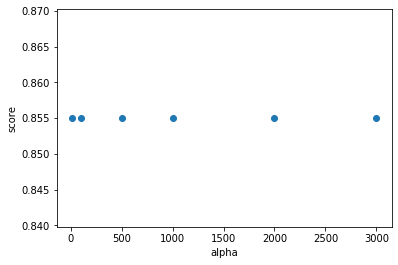

In [228]:
plt.scatter(alpha, result)
plt.xlabel("alpha")
plt.ylabel("score")
plt.show()

Alpha = 1000 for l1 penalty is optimum

In [244]:
alpha = [10, 100, 500, 1000, 1500, 2000, 2500]
result = []
for a in alpha:
    print(f"alpha: {a}" )
    model = LogisticRegression(solver='liblinear', penalty='l2', C=a)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

alpha: 10
0.8555107136427533
alpha: 100
0.8555047562449163
alpha: 500
0.855507351378509
alpha: 1000
0.8555093107401561
alpha: 1500
0.8555096362292034
alpha: 2000
0.8555093107401561
alpha: 2500
0.8555089852511089


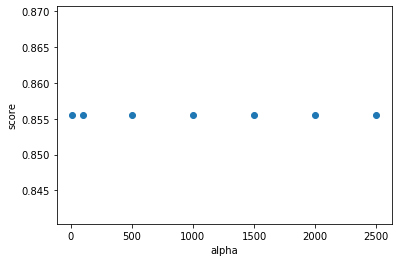

In [245]:
plt.scatter(alpha, result)
plt.xlabel("alpha")
plt.ylabel("score")
plt.show()

Alpha = 1500 for l2 penalty is optimum

In [246]:
alpha = [10, 100, 500, 1000, 1500, 2000, 2500]
result = []
for a in alpha:
    print(f"alpha: {a}" )
    model = LogisticRegression(solver='saga', 
                               penalty='elasticnet', 
                               C=a, l1_ratio=0.5,
                              max_iter=1000)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

alpha: 10
0.8555047546723091
alpha: 100
0.8555089789906342
alpha: 500
0.8555109382966519
alpha: 1000
0.8555106128076047
alpha: 1500
0.8555099618295099
alpha: 2000
0.8555109414825189
alpha: 2500
0.8555106159934714


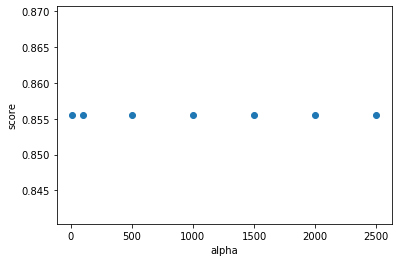

In [247]:
plt.scatter(alpha, result)
plt.xlabel("alpha")
plt.ylabel("score")
plt.show()

Alpha = 1500 for elastic net penalty is optimum

## Decision Tree

In [255]:
depth = [1, 2, 3, 4, 5, 6, 7]
result = []
for d in depth:
    print(f"depth: {d}" )
    model = DecisionTreeClassifier(max_depth=d)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

depth: 1
0.7281333383623816
depth: 2
0.769962219392559
depth: 3
0.8140614678378226
depth: 4
0.8305593887190312
depth: 5
0.8355394961285253
depth: 6
0.8203310896772461
depth: 7
0.7956806741881429


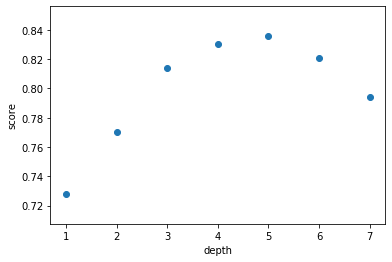

In [254]:
plt.scatter(depth, result)
plt.xlabel("depth")
plt.ylabel("score")
plt.show()

depth = 5 for decision tree is optimum. Next values lead to overfitting

In [267]:
max_leaf_nodes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
result = []
for leaf in max_leaf_nodes:
    print(f"max leaf: {leaf}" )
    model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=leaf)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

max leaf: 5
0.7501614772696575
max leaf: 10
0.7770943349389807
max leaf: 15
0.7914901854358511
max leaf: 20
0.8054176310423845
max leaf: 25
0.8202800098897868
max leaf: 30
0.8335473731226563
max leaf: 35
0.8355394961285253
max leaf: 40
0.8355394961285253
max leaf: 45
0.8355394961285253
max leaf: 50
0.8355394961285253
max leaf: 55
0.8355394961285253
max leaf: 60
0.8355394961285253
max leaf: 65
0.8355394961285253
max leaf: 70
0.8354040695429192


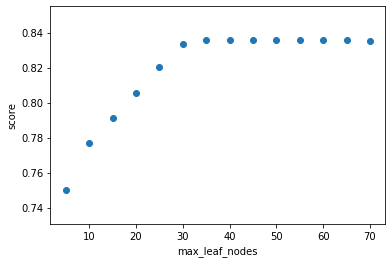

In [268]:
plt.scatter(max_leaf_nodes, result)
plt.xlabel("max_leaf_nodes")
plt.ylabel("score")
plt.show()

max_leaf_nodes = 35 is optimum. Next value is limited by depth value

In [271]:
min_samples_split = [2, 3, 4, 5, 6]
result = []
for param in min_samples_split:
    print(f"min samples split: {param}" )
    model = DecisionTreeClassifier(max_depth=5, min_samples_split=param)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

min samples split: 2
0.8354040695429192
min samples split: 3
0.8354040695429192
min samples split: 4
0.8354040695429192
min samples split: 5
0.8354047206322731
min samples split: 6
0.8354047206322731


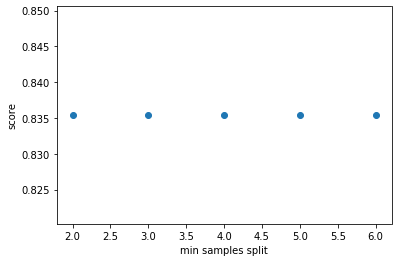

In [272]:
plt.scatter(min_samples_split, result)
plt.xlabel("min samples split")
plt.ylabel("score")
plt.show()

There are a lit bit changes in scores

## Random Forest

In [276]:
max_depth= [2, 3, 4, 5, 6]
result = []
for d in max_depth:
    print(f"depth: {d}" )
    model = RandomForestClassifier(max_depth=d, n_estimators=20)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

depth: 2
0.8474416268859188
depth: 3
0.8522975761382281
depth: 4
0.854731269433486
depth: 5
0.8569478137718706
depth: 6
0.8561403129334966


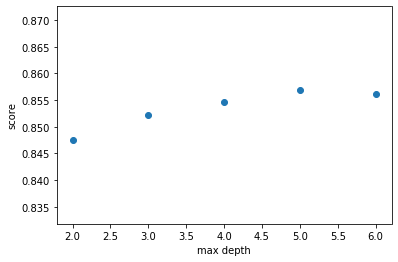

In [277]:
plt.scatter(max_depth, result)
plt.xlabel("max depth")
plt.ylabel("score")
plt.show()

Get 4 max depth to avoid overfitting

In [282]:
n_estimators = [10, 15, 20, 25, 30, 35, 40, 45, 50]
result = []
for n in n_estimators:
    print(f"n_estimators: {n}" )
    model = RandomForestClassifier(max_depth=4, n_estimators=n)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

n_estimators: 10
0.8556485502596602
n_estimators: 15
0.8534967019670265
n_estimators: 20
0.8553893357428484
n_estimators: 25
0.8542918258536212
n_estimators: 30
0.855959084604776
n_estimators: 35
0.8559449885440141
n_estimators: 40
0.8576807897371184
n_estimators: 45
0.8561886662532622
n_estimators: 50
0.8557061608303957


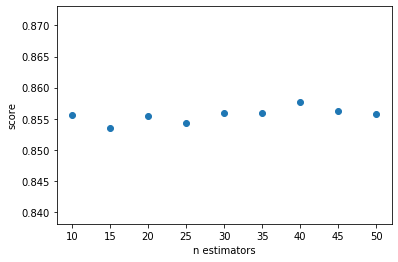

In [283]:
plt.scatter(n_estimators, result)
plt.xlabel("n estimators")
plt.ylabel("score")
plt.show()

Get 40 estimators

In [285]:
max_leaf_nodes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
result = []
for leaf in max_leaf_nodes:
    print(f"max leaf: {leaf}" )
    model = RandomForestClassifier(max_depth=4, n_estimators=40, max_leaf_nodes=leaf)
    score = get_score(X, y, model)
    print(score)
    result.append(score)

max leaf: 5
0.8534206257318301
max leaf: 10
0.8549039844710722
max leaf: 15
0.8564181320594336
max leaf: 20
0.8573065336267212
max leaf: 25
0.8556109819456392
max leaf: 30
0.8574596098337718
max leaf: 35
0.8568759238663715
max leaf: 40
0.8563272552921293
max leaf: 45
0.8568417491638989
max leaf: 50
0.8572586184471017
max leaf: 55
0.8559890157517642
max leaf: 60
0.8561615435367592
max leaf: 65
0.8541898667165893
max leaf: 70
0.8569013811329629


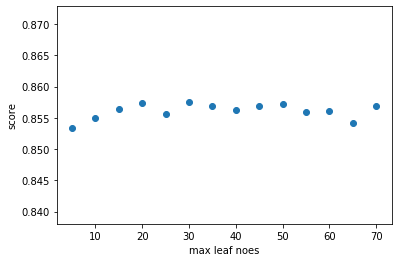

In [286]:
plt.scatter(max_leaf_nodes, result)
plt.xlabel("max leaf noes")
plt.ylabel("score")
plt.show()

30 look like optimum

## Create submission

In [65]:
def submission(X, y, sub, model, output):
    sample_sub = pd.read_csv("sample_submission.csv")
    model.fit(X, y)
    y_proba = model.predict_proba(X_sub)[:,1]
    
    sub = pd.DataFrame()
    sub["id"] = X_sub.index
    sub["stroke"] = y_proba
    sub = sub[sub["id"].isin(sample_sub['id'])]
    sub.to_csv(output, sep=',', index=False, header=True)

In [61]:
X = data_train[lv_features]
X_sub = data_test[lv_features]
y = y[X.index]

In [66]:
model = RandomForestClassifier(max_depth=4, n_estimators=40)
submission(X, y, X_sub, model, "submission_2.csv")

In [67]:
model = LogisticRegression(solver='saga', 
                               penalty='elasticnet', 
                               C=500, l1_ratio=0.5)
submission(X, y, X_sub, model, "submission_2.csv")

In [68]:
model = DecisionTreeClassifier(max_depth=5)
submission(X, y, X_sub, model, "submission_3.csv")

Result on Kaggle:
    
Random Forest - 0.86017

DecisionTree - 0.83376

Logistic Regression - 0.86677

Best: Logistic Regression